## ARMADA pipeline using orbitize

In [1]:
import numpy as np
import orbitize
from orbitize import driver,system,priors,sampler
from orbitize import read_input
import multiprocessing as mp
import os
from astropy.time import Time
from read_data import read_data,read_wds,read_orb6
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

%matplotlib inline

### First grab our ARMADA/WDS data to format it for orbitize

In [2]:
## select target, data
target = 'HD_45542_inner'
data_armada = '/Users/tgardne/ARMADA_orbits/HD_45542_wobble.txt'

In [3]:
## read in armada data
file=open(data_armada)
xpos=[]
ypos=[]  #text file is in degrees
t=[]
error_maj=[]
error_min=[]
error_pa=[]
for line in file.readlines():
    if line.startswith('#'):
        continue
    xpos.append(line.split()[1])
    ypos.append(line.split()[2])
    t.append(line.split()[0])
    error_maj.append(line.split()[3])
    error_min.append(line.split()[4])
    error_pa.append(line.split()[5])
file.close()
ypos=np.asarray([float(i) for i in ypos])
xpos=np.asarray([float(i) for i in xpos])
t=np.asarray([float(i) for i in t])

#weight=np.sqrt(0.3)
weight=1

error_maj=weight*np.asarray([float(i) for i in error_maj])
error_min=weight*np.asarray([float(i) for i in error_min])

error_deg=np.asarray([float(i) for i in error_pa])
error_pa=error_deg*np.pi/180.

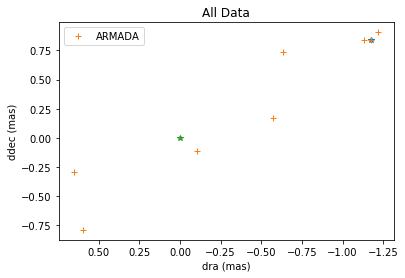

In [4]:
idx = np.argmin(t)
plt.plot(xpos[idx],ypos[idx],'*')
plt.plot(xpos,ypos,'+',label='ARMADA')
plt.plot(0,0,'*')
plt.gca().invert_xaxis()
plt.title('All Data')
plt.xlabel('dra (mas)')
plt.ylabel('ddec (mas)')
plt.legend()
plt.show()

In [5]:
## convert errors for orbitize
xerr = []
yerr = []
for i,j,k in zip(error_maj,error_min,error_deg):
    xerr1 = abs(i*np.sin(k*np.pi/180))
    xerr2 = abs(j*np.cos(k*np.pi/180))
    yerr1 = abs(i*np.cos(k*np.pi/180))
    yerr2 = abs(j*np.sin(k*np.pi/180))
    xerr.append(max(xerr1,xerr2))
    yerr.append(max(yerr1,yerr2))
xerr = np.array(xerr)
yerr = np.array(yerr)

print(xerr,yerr)

[0.053      0.03489453 0.159      0.06322376 0.07685578 0.03333974
 0.02353901 0.03456323] [0.029      0.02152607 0.029      0.06820378 0.08419732 0.05785425
 0.0253497  0.03184938]


In [6]:
## need to write to csv file for orbitize
f = open("/Users/tgardne/ARMADA_orbits/%s.csv"%target,"w+")
f.write("epoch object raoff raoff_err decoff decoff_err\r\n")
    
for i,j,k,l,m in zip(t,xpos,xerr,ypos,yerr):
    f.write("%s 1 %s %s %s %s\r\n"%(i,j,k,l,m))
f.close()

### Now initiate an orbitize run

In [7]:
## set up data file
filename = "/Users/tgardne/ARMADA_orbits/%s.csv"%target.format(orbitize.DATADIR)
data_table = read_input.read_file(filename)
data_table

epoch,object,quant1,quant1_err,quant2,quant2_err,quant_type
float64,int64,float64,float64,float64,float64,bytes5
58024.5609,1,-1.1753813942857079,0.053,0.837955044857317,0.029,radec
58026.5487,1,-1.1288948318111522,0.03489453129298713,0.8416791013104614,0.021526069911684813,radec
58381.5053,1,0.5953352642494565,0.159,-0.7886371368380694,0.029,radec
58443.462,1,-0.10221945165348245,0.0632237613784652,-0.11521508831917515,0.06820378286546057,radec
58456.3938,1,-1.220330823227954,0.07685577814995175,0.9057379352492632,0.08419732397746024,radec
58734.5365,1,-0.6344287185857809,0.03333973511495279,0.7368738035963105,0.05785424622888867,radec
58769.5102,1,-0.5738185628879933,0.023539010679327475,0.17260788285168616,0.025349703808506513,radec
58798.4763,1,0.6509928636163806,0.03456322945670774,-0.28885913954016473,0.03184938256109481,radec


In [8]:
## select system parameters
num_secondary_bodies = 1
system_mass = 6 # [Msol]
plx = 5.99 # [mas]
mass_err = 1 # [Msol]
plx_err = 0 # [mas]

# MCMC parameters
num_temps = 20
num_walkers = 1000
num_threads = mp.cpu_count() # or a different number if you prefer

In [9]:
## modify parameters
sys = system.System(
    num_secondary_bodies, data_table, system_mass,
    plx, mass_err=mass_err, plx_err=plx_err)

print(sys.labels)
print(sys.sys_priors)
print(sys.param_idx)

# alias for convenience
lab = sys.param_idx

['sma1', 'ecc1', 'inc1', 'aop1', 'pan1', 'tau1', 'plx', 'mtot']
[Log Uniform, Uniform, Sine, Uniform, Uniform, Uniform, 5.99, Gaussian]
{'sma1': 0, 'ecc1': 1, 'inc1': 2, 'aop1': 3, 'pan1': 4, 'tau1': 5, 'plx': 6, 'mtot': 7}


In [10]:
## change mtot to uniform
sys.sys_priors[lab['mtot']] = priors.UniformPrior(2,10)

## limit Omega to <180deg (IF NO RV)
sys.sys_priors[lab['pan1']] = priors.UniformPrior(0,np.pi)

## I find uniform prior better for semi-major
sys.sys_priors[lab['sma1']] = priors.UniformPrior(0,1)

print(sys.labels)
print(sys.sys_priors)
print(sys.param_idx)

['sma1', 'ecc1', 'inc1', 'aop1', 'pan1', 'tau1', 'plx', 'mtot']
[Uniform, Uniform, Sine, Uniform, Uniform, Uniform, 5.99, Uniform]
{'sma1': 0, 'ecc1': 1, 'inc1': 2, 'aop1': 3, 'pan1': 4, 'tau1': 5, 'plx': 6, 'mtot': 7}


### Now Run the MCMC

In [11]:
## setup a run
my_driver = driver.Driver(
    filename, 'MCMC', num_secondary_bodies, system_mass, plx, mass_err=mass_err, plx_err=plx_err,
    mcmc_kwargs={'num_temps': num_temps, 'num_walkers': num_walkers, 'num_threads': num_threads})

In [12]:
## run the chains
total_orbits = 500000 # number of steps x number of walkers (at lowest temperature)
burn_steps = 200 # steps to burn in per walker
thin = 2 # only save every 2nd step

#my_driver.sampler.run_sampler(total_orbits, burn_steps=burn_steps, thin=thin)

mcmc_sampler = sampler.MCMC(sys, num_temps, num_walkers, num_threads)
mcmc_sampler.run_sampler(total_orbits, burn_steps=burn_steps, thin=thin)

/Users/tgardne/.local/lib/python3.7/site-packages/orbitize/priors.py:277: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/tgardne/.local/lib/python3.7/site-packages/orbitize/priors.py:277: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/tgardne/.local/lib/python3.7/site-packages/orbitize/priors.py:277: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/tgardne/.local/lib/python3.7/site-packages/orbitize/priors.py:277: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/tgardne/.local/lib/python3.7/site-packages/orbitize/priors.py:277: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/tgardne/.local/lib/python3.7/site-packages/orbitize/priors.py:277: RuntimeWarning: invalid value encoun

Burn in complete
500/500 steps completed
Run complete


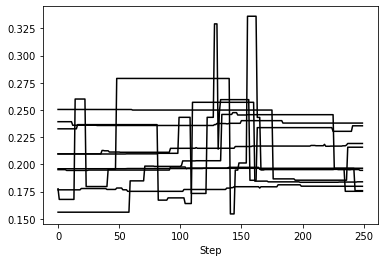

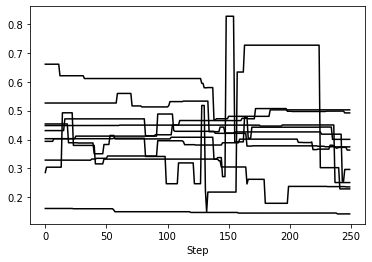

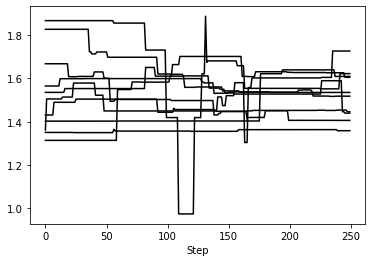

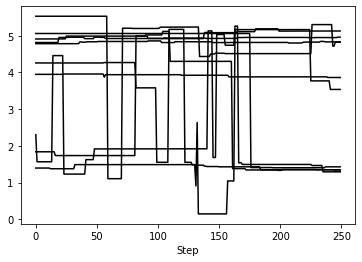

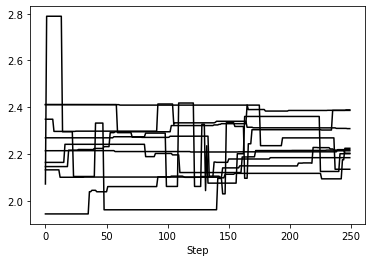

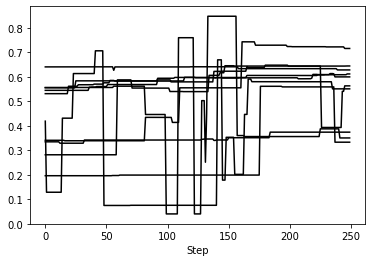

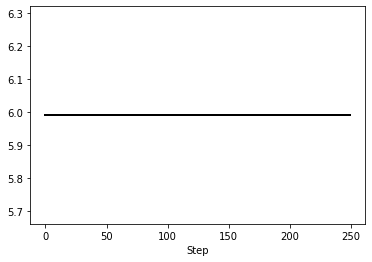

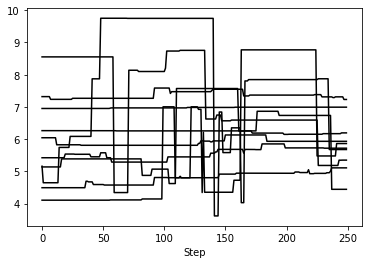

In [13]:
## example for how to look at chains:
#ecc_chains = my_driver.sampler.examine_chains(n_walkers=10)#(param_list=['ecc1'])
ecc_chains = mcmc_sampler.examine_chains(n_walkers=10)#(param_list=['ecc1'])

[0.19385539 0.42559729 1.51920395 4.80268242 2.24178379 0.55618761
 6.1112918 ]


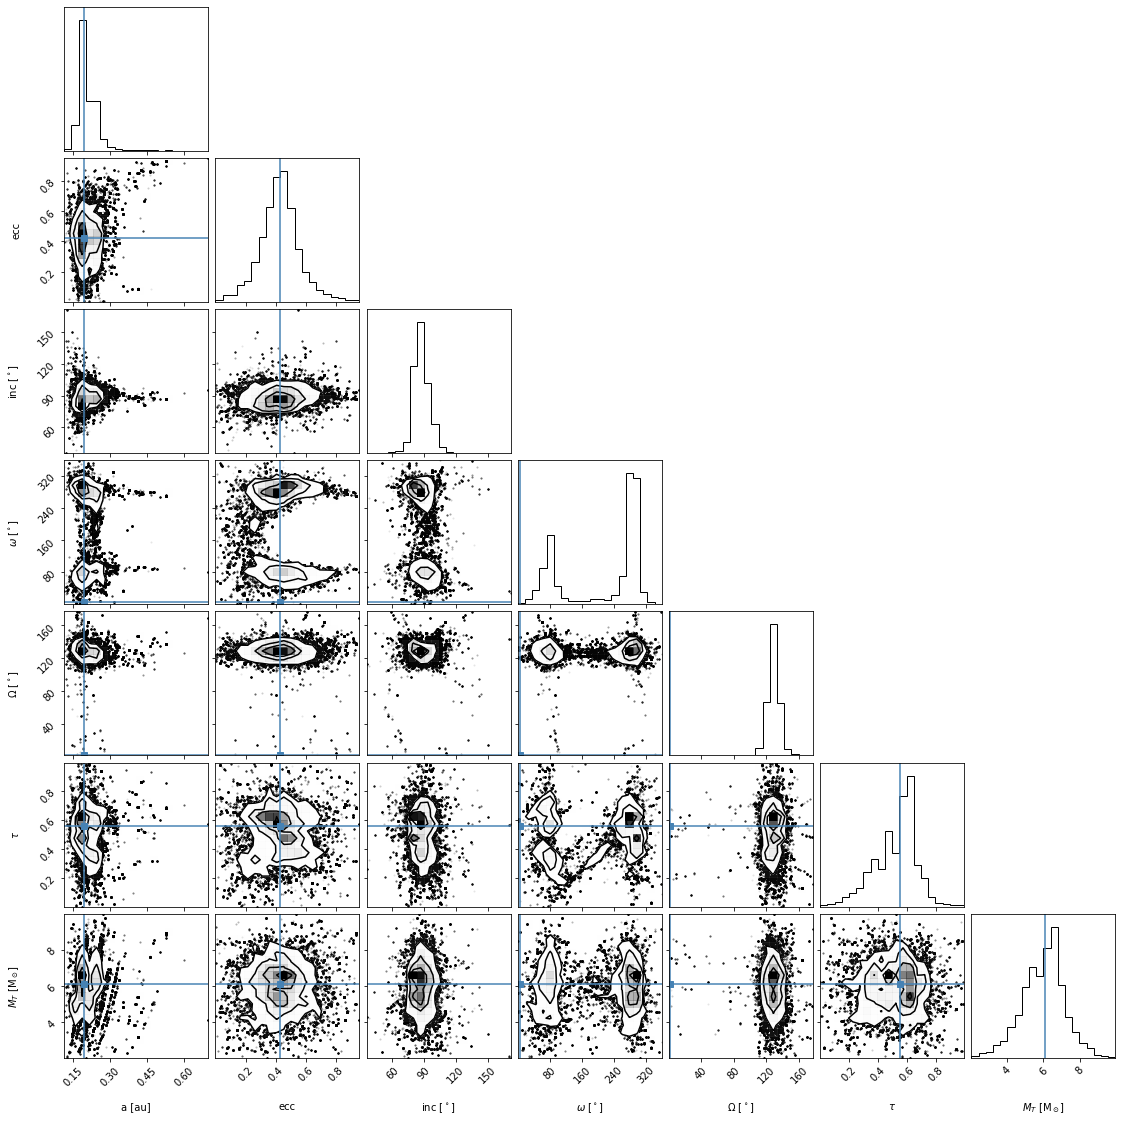

In [14]:
#corner_plot_fig = my_driver.sampler.results.plot_corner(param_list=['sma1', 'ecc1', 'inc1', 'aop1', 'pan1','tau1', 'mtot']) # Creates a corner plot and returns Figure object
median_values = np.median(mcmc_sampler.results.post,axis=0) # Compute median of each parameter
range_values = np.ones_like(median_values)*0.95 # Plot only 95% range for each parameter

median_values = np.delete(median_values,6)
range_values = np.delete(range_values,6)

print(median_values)

corner_plot_fig = mcmc_sampler.results.plot_corner(param_list=['sma1', 'ecc1', 'inc1', 'aop1', 'pan1','tau1', 'mtot'],
                                                  truths=median_values)#,range=range_values)
corner_plot_fig.savefig('/Users/tgardne/ARMADA_orbits/%s_corner.png'%target) # This is matplotlib.figure.Figure.savefig()

/Users/tgardne/.conda/envs/testenv/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 1008x432 with 0 Axes>

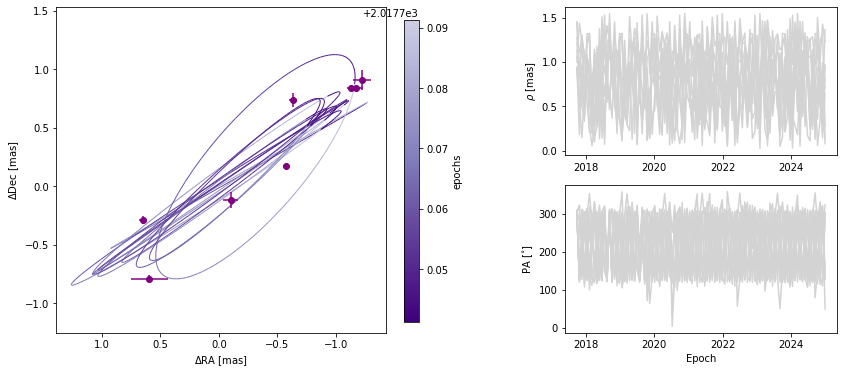

In [17]:
# plot orbits
#orb_fig = my_driver.sampler.results.plot_orbits(start_mjd=t_wds[0], num_orbits_to_plot=100)
orb_fig = mcmc_sampler.results.plot_orbits(start_mjd=t[0], num_orbits_to_plot=10)


ax_orb, ax_cbar, ax_sep, ax_pa  = orb_fig.axes

data_tab = my_driver.system.data_table

epochs_yr = Time(data_tab['epoch'], format='mjd').decimalyear
epochs_armada = Time(t, format='mjd').decimalyear

xdata = data_tab['quant1']; xdata_err = data_tab['quant1_err']
ydata = data_tab['quant2']; ydata_err = data_tab['quant2_err']

#### ARMADA #######
## add data to orbit panel
ax_orb.errorbar(
    xpos, ypos, xerr=xerr, yerr=yerr,
    color='purple', linestyle='', fmt='o', zorder=4)

orb_fig.show()

In [20]:
median_values = np.median(mcmc_sampler.results.post,axis=0) # Compute median of each parameter
print(median_values)

period = np.sqrt(median_values[0]**3 / median_values[-1])
semi = median_values[0] * median_values[6]

print("Period = ", period, period*365.25)
print("a = ", semi)

[0.17383618 0.46427142 1.57476387 3.93015412 1.99470634 0.4837177
 5.99       4.97486462]
Period =  0.032495230836489204 11.868883063027681
a =  1.0412787263483578


## Include a second component!

In [116]:
## select system parameters
num_secondary_bodies = 2
m0 = 4 # [Msol]
plx = 5.99 # [mas]
mass_err = 0 # [Msol]
plx_err = 0 # [mas]

# MCMC parameters
num_temps = 20
num_walkers = 1000
num_threads = mp.cpu_count() # or a different number if you prefer

In [117]:
## modify parameters
sys = system.System(
    num_secondary_bodies, data_table, system_mass,
    plx, mass_err=mass_err, plx_err=plx_err, fit_secondary_mass=True)

print(sys.labels)
print(sys.sys_priors)
print(sys.param_idx)

# alias for convenience
lab = sys.param_idx

['sma1', 'ecc1', 'inc1', 'aop1', 'pan1', 'tau1', 'sma2', 'ecc2', 'inc2', 'aop2', 'pan2', 'tau2', 'plx', 'm1', 'm2', 'm0']
[Log Uniform, Uniform, Sine, Uniform, Uniform, Uniform, Log Uniform, Uniform, Sine, Uniform, Uniform, Uniform, 5.99, Log Uniform, Log Uniform, 6]
{'sma1': 0, 'ecc1': 1, 'inc1': 2, 'aop1': 3, 'pan1': 4, 'tau1': 5, 'sma2': 6, 'ecc2': 7, 'inc2': 8, 'aop2': 9, 'pan2': 10, 'tau2': 11, 'plx': 12, 'm1': 13, 'm2': 14, 'm0': 15}


In [118]:
## change mtot to uniform
#sys.sys_priors[lab['m0']] = priors.UniformPrior(0,10)
sys.sys_priors[lab['m1']] = priors.UniformPrior(0,10)
sys.sys_priors[lab['m2']] = priors.UniformPrior(0,10)

## limit Omega to <180deg (IF NO RV)
sys.sys_priors[lab['pan1']] = priors.UniformPrior(0,np.pi)
sys.sys_priors[lab['pan2']] = priors.UniformPrior(0,np.pi)

## I find uniform prior better for semi-major
sys.sys_priors[lab['sma1']] = priors.UniformPrior(0,50)
sys.sys_priors[lab['sma2']] = priors.UniformPrior(0,50)

print(sys.labels)
print(sys.sys_priors)
print(sys.param_idx)

['sma1', 'ecc1', 'inc1', 'aop1', 'pan1', 'tau1', 'sma2', 'ecc2', 'inc2', 'aop2', 'pan2', 'tau2', 'plx', 'm1', 'm2', 'm0']
[Uniform, Uniform, Sine, Uniform, Uniform, Uniform, Uniform, Uniform, Sine, Uniform, Uniform, Uniform, 5.99, Uniform, Uniform, 6]
{'sma1': 0, 'ecc1': 1, 'inc1': 2, 'aop1': 3, 'pan1': 4, 'tau1': 5, 'sma2': 6, 'ecc2': 7, 'inc2': 8, 'aop2': 9, 'pan2': 10, 'tau2': 11, 'plx': 12, 'm1': 13, 'm2': 14, 'm0': 15}


In [119]:
## setup a run
my_driver = driver.Driver(
    filename, 'MCMC', num_secondary_bodies, system_mass, plx, mass_err=mass_err, plx_err=plx_err,
    mcmc_kwargs={'num_temps': num_temps, 'num_walkers': num_walkers, 'num_threads': num_threads})

In [120]:
## run the chains
total_orbits = 100000 # number of steps x number of walkers (at lowest temperature)
burn_steps = 50 # steps to burn in per walker
thin = 2 # only save every 2nd step

#my_driver.sampler.run_sampler(total_orbits, burn_steps=burn_steps, thin=thin)

mcmc_sampler = sampler.MCMC(sys, num_temps, num_walkers, num_threads)
mcmc_sampler.run_sampler(total_orbits, burn_steps=burn_steps, thin=thin)

/Users/tgardne/.local/lib/python3.7/site-packages/orbitize/priors.py:277: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/tgardne/.local/lib/python3.7/site-packages/orbitize/priors.py:277: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/tgardne/.local/lib/python3.7/site-packages/orbitize/priors.py:277: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/tgardne/.local/lib/python3.7/site-packages/orbitize/priors.py:277: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/tgardne/.local/lib/python3.7/site-packages/orbitize/priors.py:277: RuntimeWarning: invalid value encountered in log
  lnprob = np.log(np.sin(element_array)/normalization)
/Users/tgardne/.local/lib/python3.7/site-packages/orbitize/priors.py:277: RuntimeWarning: invalid value encoun

Burn in complete
100/100 steps completed
Run complete


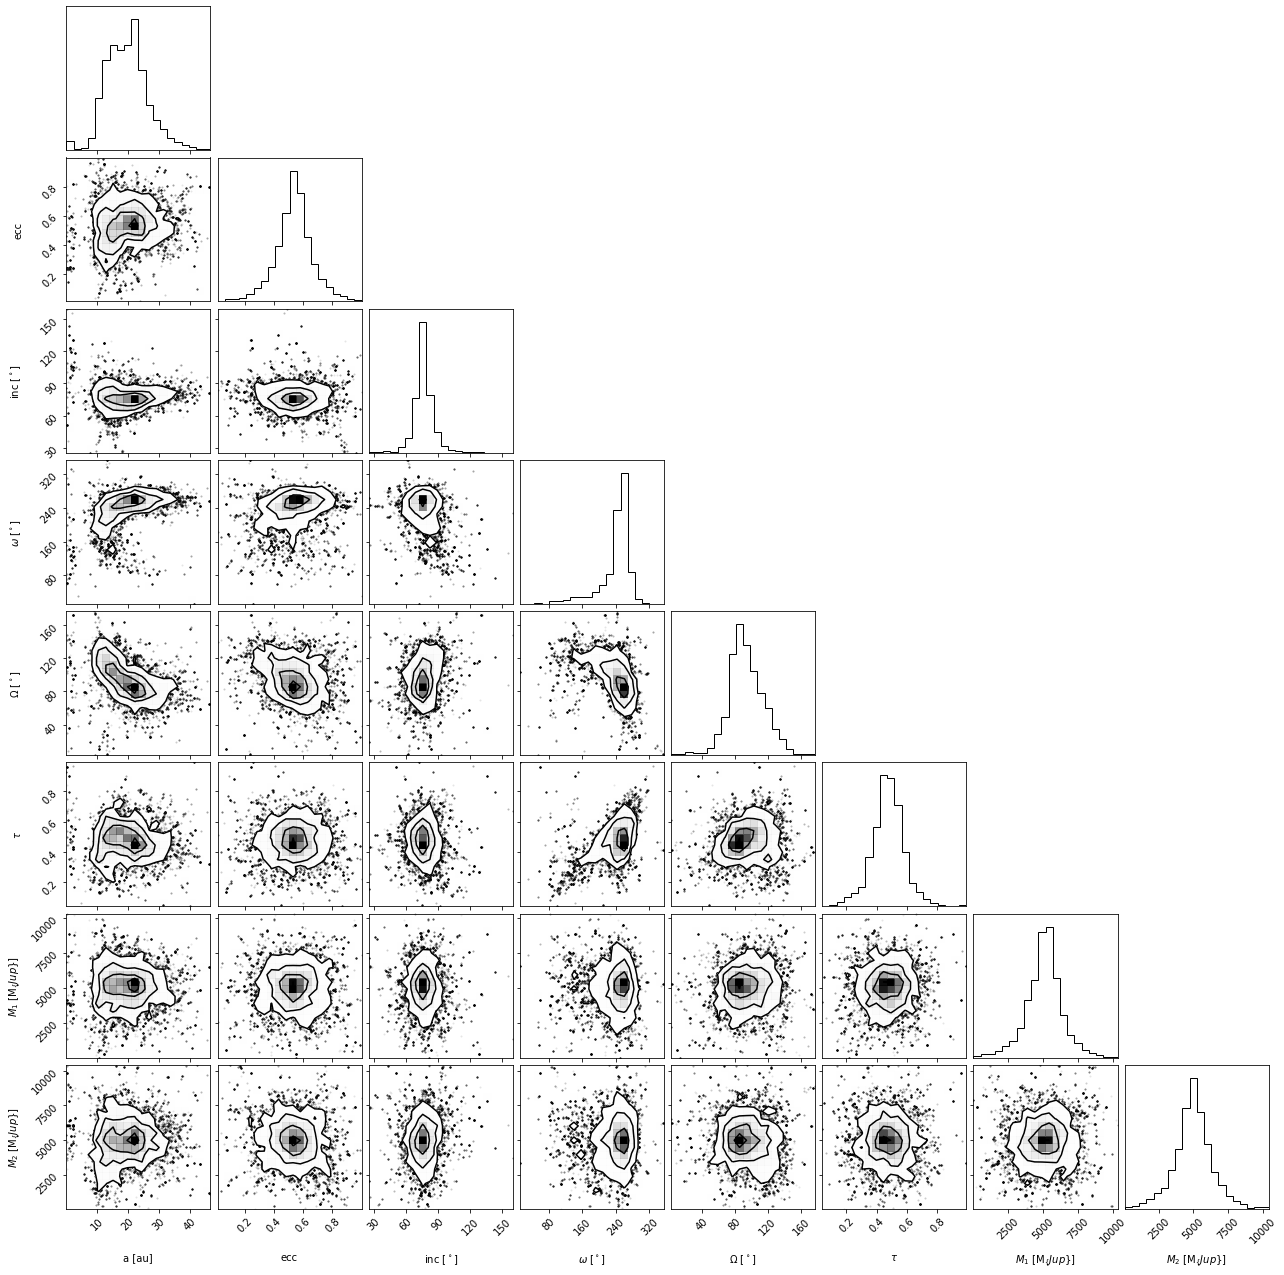

In [122]:
corner_plot_fig = mcmc_sampler.results.plot_corner(param_list=['sma1', 'ecc1', 'inc1', 'aop1', 'pan1','tau1', 'm1', 'm2'])
corner_plot_fig.savefig('/Users/tgardne/ARMADA_orbits/%s_corner_triple_star.png'%target) # This is matplotlib.figure.Figure.savefig()

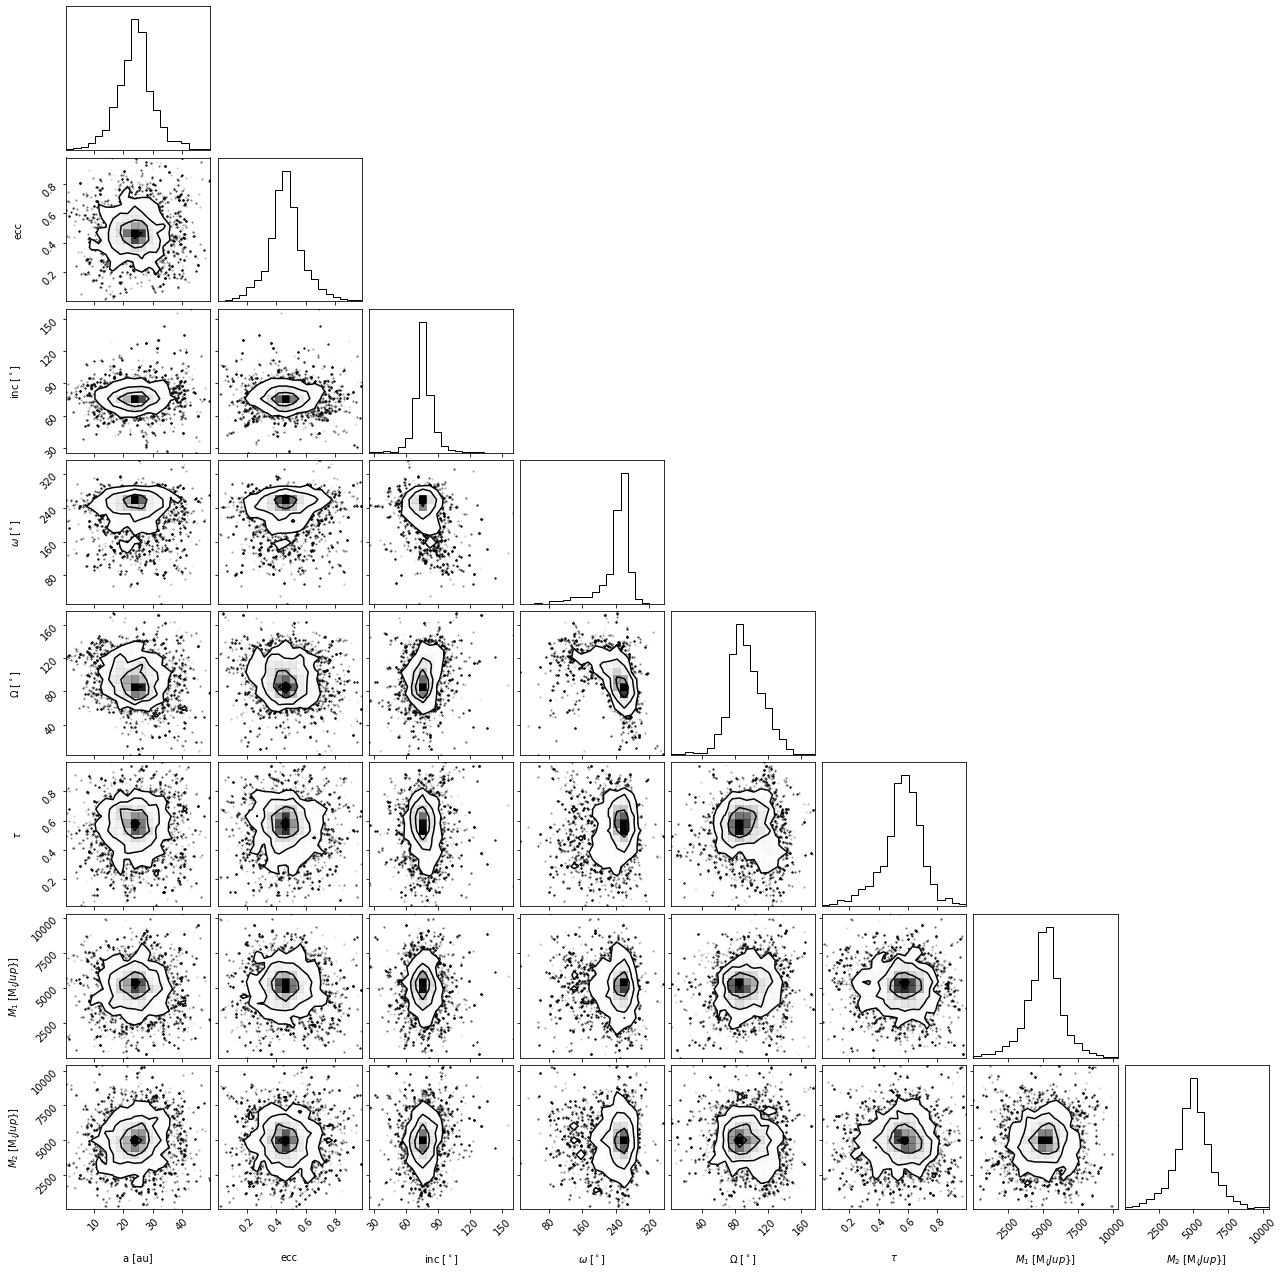

In [123]:
corner_plot_fig = mcmc_sampler.results.plot_corner(param_list=['sma2', 'ecc2', 'inc2', 'aop2', 'pan2','tau2', 'm1', 'm2']) # Creates a corner plot and returns Figure object
corner_plot_fig.savefig('/Users/tgardne/ARMADA_orbits/%s_corner_triple_planet.png'%target) # This is matplotlib.figure.Figure.savefig()

/Users/tgardne/.conda/envs/testenv/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 1008x432 with 0 Axes>

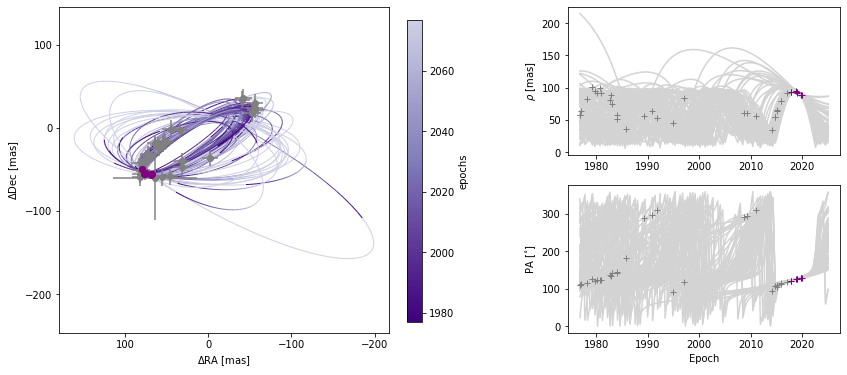

In [106]:
# plot orbits
orb_fig = mcmc_sampler.results.plot_orbits(start_mjd=t_wds[0], num_orbits_to_plot=100)
ax_orb, ax_cbar, ax_sep, ax_pa  = orb_fig.axes

data_tab = my_driver.system.data_table

epochs_yr = Time(data_tab['epoch'], format='mjd').decimalyear
epochs_armada = Time(t, format='mjd').decimalyear
epochs_wds = Time(t_wds, format='mjd').decimalyear

xdata = data_tab['quant1']; xdata_err = data_tab['quant1_err']
ydata = data_tab['quant2']; ydata_err = data_tab['quant2_err']

#### ARMADA #######
## add data to sep panel
ax_sep.plot(
    epochs_armada, p, '+',
    color='purple', zorder=4)
## add data to PA panel
ax_pa.plot(
    epochs_armada, theta*180/np.pi, '+',
    color='purple', zorder=4)
## add data to orbit panel
ax_orb.errorbar(
    xpos, ypos, xerr=xerr, yerr=yerr,
    color='purple', linestyle='', fmt='o', zorder=4)

##### WDS #######
## add data to sep panel
ax_sep.plot(
    epochs_wds, p_wds, '+',
    color='grey', zorder=3)
## add data to PA panel
ax_pa.plot(
    epochs_wds, theta_wds*180/np.pi, '+',
    color='grey', zorder=3)
## add data to orbit panel
ax_orb.errorbar(
    xpos_wds, ypos_wds, xerr=xerr_wds, yerr=yerr_wds,
    color='grey', linestyle='', fmt='o', zorder=3)

orb_fig.show()